In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    brier_score_loss,
)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from fairness_measures import *

df = pd.read_csv("all_vals_race1_interestrate1.csv")

df["default_2_years"] = np.where((df["default"] == 1) & (df["default_age"] <= 24), 1, 0)

df["default_3_years"] = np.where((df["default"] == 1) & (df["default_age"] <= 36), 1, 0)

df.drop(
    columns=[
        "IsTestData",
        "IsCalibrateData",
        "v1",
        "istestdata2",
        "iscalibratedata2",
    ],
    inplace=True,
)


df["minority"] = (
    (df["race_dum_Black"] == 1)
    | (df["race_dum_Native Am, Alaska, Hawaii"] == 1)
    | (df["ethnicity_dum_hisp"] == 1)
    # | (df['race_dum_Asian'] == 1)
)


valid_race_cols = [
    "race_dum_White hisp",
    "race_dum_Unknown",
    "race_dum_White_non_hisp",
    "race_dum_Asian",
    "race_dum_Black",
    "race_dum_Native Am, Alaska, Hawaii",
]

df = df[df[valid_race_cols].sum(axis=1) == 1].copy()
df

features = df.drop(
    columns=[
        "default",
        "default_2_years",
        "default_3_years",
        "cur_int_rate",
        "sato",
        "minority",
        "default_age",
        "prepayment",
        "zip",
        "COUNTY",
        # "log_org_amt",
        # 'orig_amt', 'fico_orig_miss', 'income_miss',
        "document_type_dum_1",
        "document_type_dum_2",
        "document_type_dum_3",
        # # 'loan_purpose_dum_1', 'orig_year_dum_2018',
        # "race_dum_Unknown",
        # "race_dum_Asian",
        # "race_dum_Black",
        # "race_dum_Native Am, Alaska, Hawaii",
        # "race_dum_White hisp",
        "ethnicity_dum_hisp",
        "race_dum_White_non_hisp",
        "loan_purpose_dum_1",
        "loan_purpose_dum_2",
        "orig_year_dum_2018",
        "prop_state_dum_CT",
        "loan_Conventional",
        "orig_year_dum_2024",
    ],
    axis=1,
)

target = df["default_3_years"]

sensitive_features = df["minority"]

C:\Users\bencu\AppData\Local\Temp\ipykernel_44816\2778943400.py:29: DtypeWarning: Columns (101) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("all_vals_race1_interestrate1.csv")


In [2]:
print(df.count())

applicant_income    1282318
income_miss         1282318
ltv_ratio_fill      1282318
fico_orig_miss      1282318
fico_orig_fill      1282318
                     ...   
zip                 1282309
COUNTY              1282318
default_2_years     1282318
default_3_years     1282318
minority            1282318
Length: 100, dtype: int64


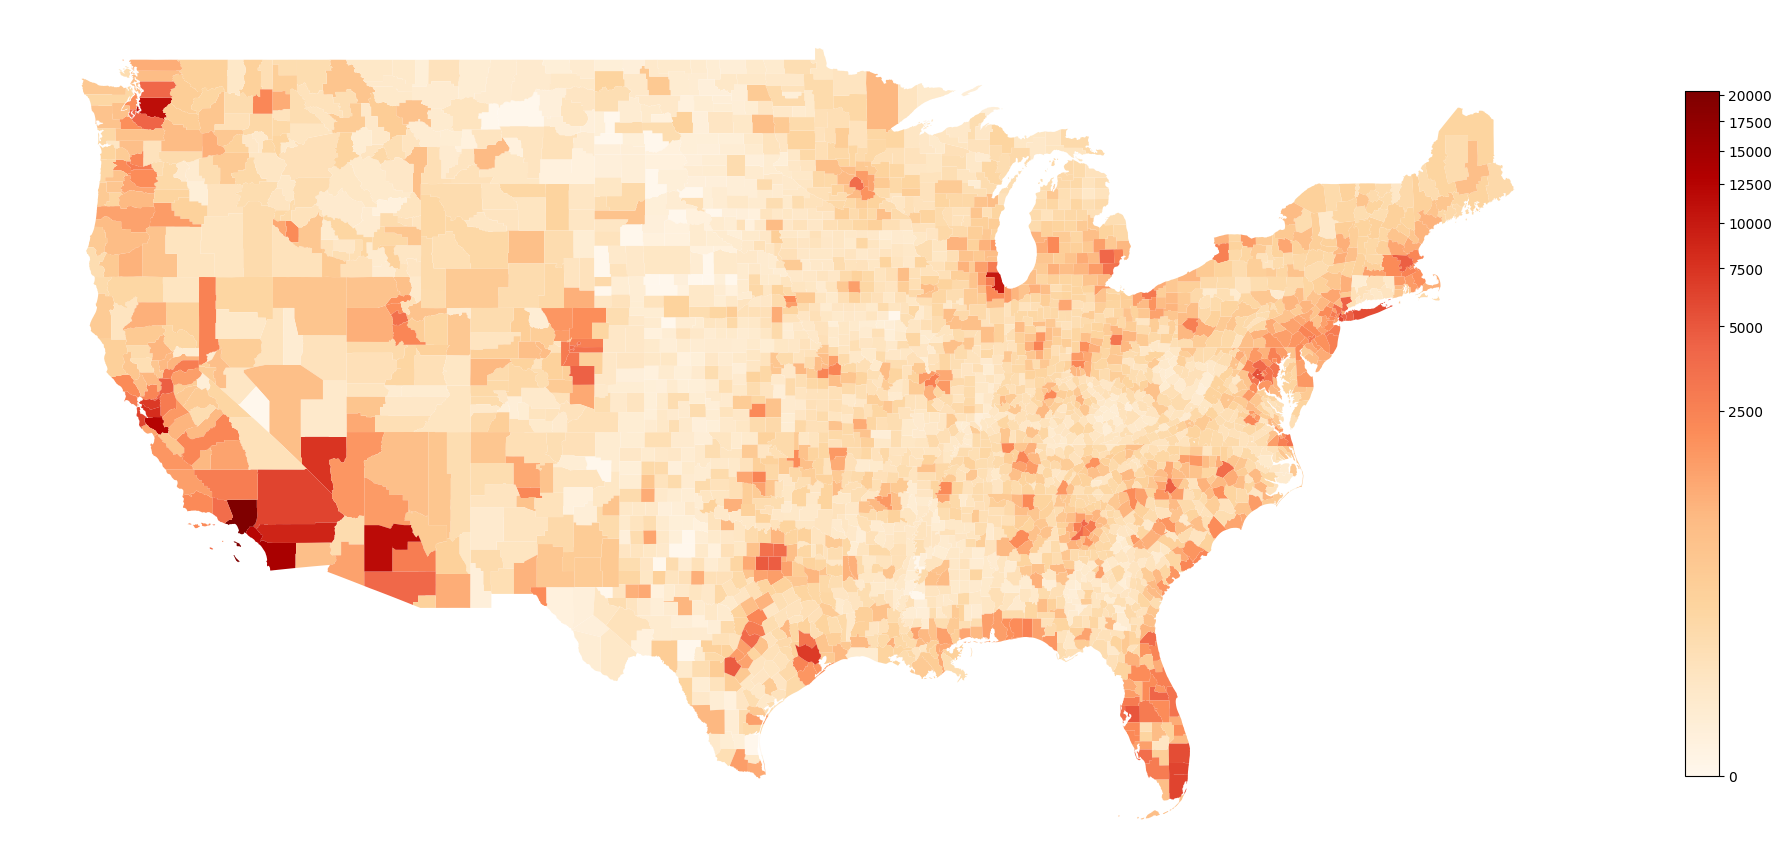

Min count: 0.0 Max count: 20344.0


In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm

# df must have a column "COUNTY" with county FIPS codes (as strings or ints)


def plot_county_heatmap(df):
    df = df.copy()
    mask = df["COUNTY"].astype(str).str.replace(".", "", regex=False).str.isdigit()
    df = df[mask]
    df["COUNTY"] = (
        df["COUNTY"]
        .astype(str)
        .str.replace(".0", "", regex=False)  # remove trailing .0
        .astype(int)
        .astype(str)
        .str.zfill(5)
    )

    # ensure proper 5-digit FIPS
    df["COUNTY"] = df["COUNTY"].astype(str).str.zfill(5)

    # compute counts
    counts = df.groupby("COUNTY").size().reset_index(name="COUNT")

    # load county geometries
    counties = gpd.read_file(
        "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_5m.zip"
    )
    counties["COUNTYFP_FULL"] = counties["STATEFP"] + counties["COUNTYFP"]

    # lower-48 only
    lower48 = counties[~counties["STATEFP"].isin(["02", "15", "60", "66", "69", "72", "78"])]

    # merge
    merged = lower48.merge(counts, left_on="COUNTYFP_FULL", right_on="COUNTY", how="left")

    # fill missing with zero
    merged["COUNT"] = merged["COUNT"].fillna(0)

    # force variation by setting color scale explicitly
    vmin = merged["COUNT"].min()
    vmax = merged["COUNT"].max()

    fig, ax = plt.subplots(figsize=(20, 14))

    norm = PowerNorm(gamma=0.3, vmin=vmin, vmax=vmax)
    # norm = (
    #     LogNorm(vmin=max(merged["COUNT"].min(), 1), vmax=merged["COUNT"].max()),
    # )

    merged.plot(
        column="COUNT",
        ax=ax,
        legend=True,
        linewidth=0,
        cmap="OrRd",
        norm=norm,
        legend_kwds={"shrink": 0.5},
    )
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

    print("Min count:", vmin, "Max count:", vmax)


plot_county_heatmap(df)

In [8]:
X_train, X_val, y_train, y_val, sensitive_train, sensitive_val = train_test_split(
    features, target, sensitive_features, test_size=0.3, random_state=42
)

In [9]:
corr_matrix = X_train.corr().abs()

# Select upper triangle only
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify highly correlated columns (e.g., correlation > 0.95)
high_corr = [col for col in upper.columns if any(upper[col] > 0.95)]
print("Highly correlated features (potential multicollinearity):", high_corr)

# Optional: check for columns with zero variance
zero_var = [col for col in X_train.columns if X_train[col].nunique() <= 1]
print("Columns with zero variance:", zero_var)

Highly correlated features (potential multicollinearity): ['fico_orig_fill', 'occupancy_type_dum_2']
Columns with zero variance: []


In [10]:
X_train['fico_orig_fill'].value_counts()

fico_orig_fill
0.0      145962
797.0      7615
801.0      7311
790.0      6841
798.0      6475
          ...  
460.0         1
477.0         1
480.0         1
498.0         1
466.0         1
Name: count, Length: 375, dtype: int64

                           Logit Regression Results                           
Dep. Variable:        default_3_years   No. Observations:               897622
Model:                          Logit   Df Residuals:                   897542
Method:                           MLE   Df Model:                           79
Date:                Sun, 16 Nov 2025   Pseudo R-squ.:                  0.1602
Time:                        23:24:18   Log-Likelihood:            -1.7003e+05
converged:                       True   LL-Null:                   -2.0246e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  6.9942      0.540     12.944      0.000       5.935       8.053
applicant_income                   -1.304e-05   8.26e-06   

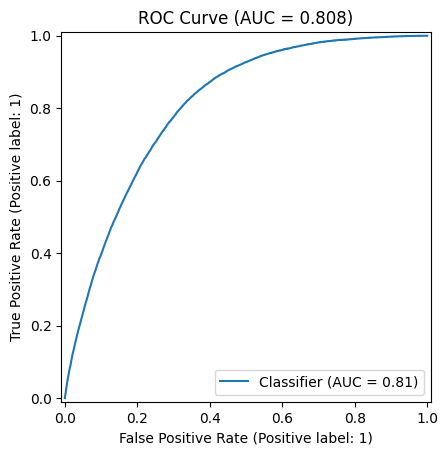

PR AUC: 0.18939934571595632


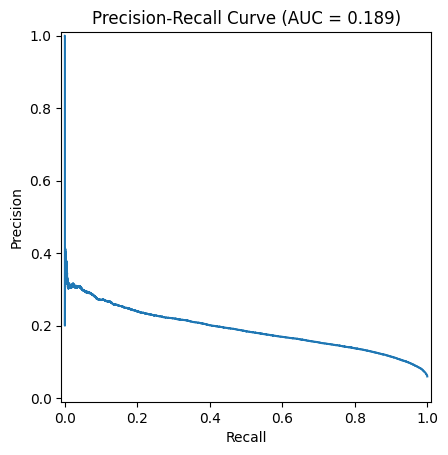

Confusion Matrix:
           Pred 0  Pred 1
Actual 0  361597      67
Actual 1   22992      40
Brier Score (x10): 0.519
Precision: 0.374
R^2: 0.078


In [11]:
X_train_const = sm.add_constant(X_train)
X_val_const = sm.add_constant(X_val)

logit_model = sm.Logit(y_train, X_train_const).fit(disp=False)
print(logit_model.summary())

y_prob = logit_model.predict(X_val_const)
y_pred = (y_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC:", roc_auc)
RocCurveDisplay.from_predictions(y_val, y_prob)
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_prob)
pr_auc = auc(recall_vals, precision_vals)
print("PR AUC:", pr_auc)
PrecisionRecallDisplay(precision_vals, recall_vals).plot()
plt.title(f"Precision-Recall Curve (AUC = {pr_auc:.3f})")
plt.show()

cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print("Confusion Matrix:\n", cm_df)

brier = brier_score_loss(y_val, y_prob) * 10
precision_val = precision_score(y_val, y_pred)
r2_val = r2_score(y_val, y_prob)

print(f"Brier Score (x10): {brier:.3f}")
print(f"Precision: {precision_val:.3f}")
print(f"R^2: {r2_val:.3f}")

ROC AUC: 0.7914523089228943


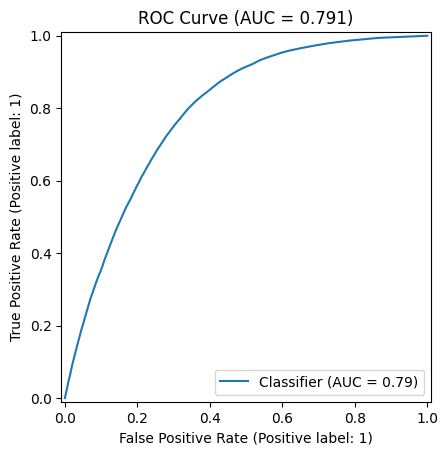

PR AUC: 0.1658731135772503


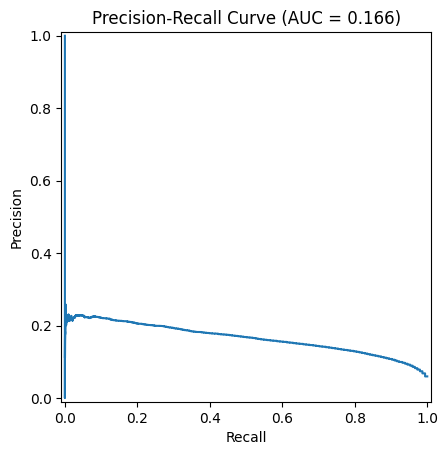

Confusion Matrix:
           Pred 0  Pred 1
Actual 0  361250     414
Actual 1   22914     118
Brier Score (x10): 0.533
Precision: 0.222
R^2: 0.053


In [6]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(n_estimators=500, max_depth=None, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_prob = rf_model.predict_proba(X_val)[:, 1]
y_pred = rf_model.predict(X_val)

roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC:", roc_auc)
RocCurveDisplay.from_predictions(y_val, y_prob)
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_prob)
pr_auc = auc(recall_vals, precision_vals)
print("PR AUC:", pr_auc)
PrecisionRecallDisplay(precision_vals, recall_vals).plot()
plt.title(f"Precision-Recall Curve (AUC = {pr_auc:.3f})")
plt.show()

cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print("Confusion Matrix:\n", cm_df)

brier = brier_score_loss(y_val, y_prob) * 10
precision_val = precision_score(y_val, y_pred)
r2_val = r2_score(y_val, y_prob)

print(f"Brier Score (x10): {brier:.3f}")
print(f"Precision: {precision_val:.3f}")
print(f"R^2: {r2_val:.3f}")

ROC AUC: 0.7750282734904417


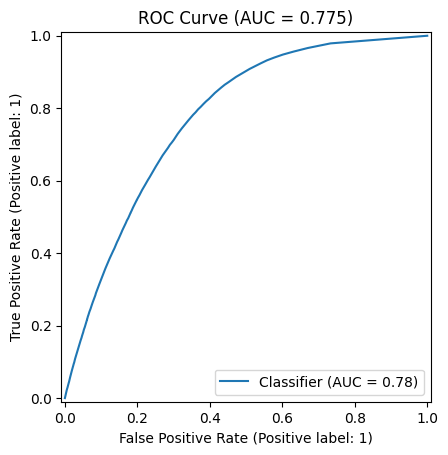

PR AUC: 0.15221203951747053


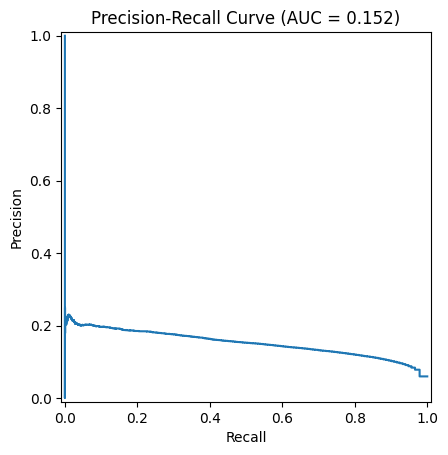

Confusion Matrix:
           Pred 0  Pred 1
Actual 0  360847     817
Actual 1   22787     245
Brier Score (x10): 0.550
Precision: 0.231
R^2: 0.023


In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=1.0,
    max_features=1.0,
    random_state=42,
    n_jobs=-1,
)
bag_model.fit(X_train, y_train)

# 2. Predictions
y_prob = bag_model.predict_proba(X_val)[:, 1]
y_pred = bag_model.predict(X_val)

# 3. ROC AUC
roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC:", roc_auc)
RocCurveDisplay.from_predictions(y_val, y_prob)
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.show()

# 4. Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_prob)
pr_auc = auc(recall_vals, precision_vals)
print("PR AUC:", pr_auc)
PrecisionRecallDisplay(precision_vals, recall_vals).plot()
plt.title(f"Precision-Recall Curve (AUC = {pr_auc:.3f})")
plt.show()

# 5. Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
print("Confusion Matrix:\n", cm_df)

# 6. Additional metrics
brier = brier_score_loss(y_val, y_prob) * 10
precision_val = precision_score(y_val, y_pred)
r2_val = r2_score(y_val, y_prob)

print(f"Brier Score (x10): {brier:.3f}")
print(f"Precision: {precision_val:.3f}")
print(f"R^2: {r2_val:.3f}")